# Train a small MNIST classifier that can be used by the Starlette app to make predictions.

The 1st version of this notebook used a resnet34 - the model used now is nearly 500 times smaller (resnet34 total params: 21,817,674 vs current model total params: 44,518).

Hopefully, this notebook is also a pretty simple example of building your own pytorch model and training it with fastai.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = untar_data(URLs.MNIST); path

PosixPath('/home/peter/.fastai/data/mnist_png')

TODO: try `tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])` from course-v3/nbs/dl1/lesson7-resnet-mnist.ipynb

In [4]:
tfms = get_transforms(do_flip=False)

In [5]:
data = ImageDataBunch.from_folder(path, train='training', valid='testing', ds_tfms=tfms, 
                                  size=28, bs=128).normalize()

In [6]:
data

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/peter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/peter/.fastai/data/mnist_png;

Test: None

### Model notes
- we're trying to build the most accurate classifier possible with a couple of constraints;
    - we can train for just 1 epoch
    - the model must be small - try for less than 100k tranable params
- downsampling with a stride 2 conv ~doubles model size and reduces accuracy a little


In [7]:
def conv_block(in_channels, out_channels, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d((2,2)))

def fc_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU())

def new_model():
    return nn.Sequential(
        conv_block(3, 32, padding=2),
        conv_block(32, 32),
        conv_block(32, 32),
        nn.Flatten(),
        fc_block(288, 84),
        nn.Linear(84, 10))

If you'd like to play around with resnets, replace the cell below with something like;

`learn = cnn_learner(data, models.resnet34, metrics=accuracy)`

In [8]:
learn = Learner(data, new_model(), metrics=accuracy)

In [9]:
learn.summary() # Loss function: FlattenedLoss of CrossEntropyLoss()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 30, 30]         896        True      
______________________________________________________________________
ReLU                 [32, 30, 30]         0          False     
______________________________________________________________________
MaxPool2d            [32, 15, 15]         0          False     
______________________________________________________________________
Conv2d               [32, 15, 15]         9,248      True      
______________________________________________________________________
ReLU                 [32, 15, 15]         0          False     
______________________________________________________________________
MaxPool2d            [32, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 7, 7]           9,248      True      
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


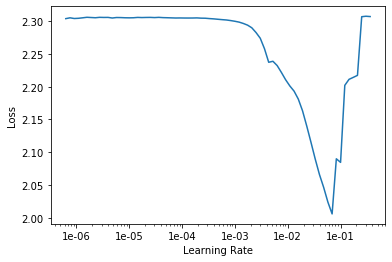

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.061429,0.027403,0.990100,00:10


## Take a look at what the trained model gets wrong

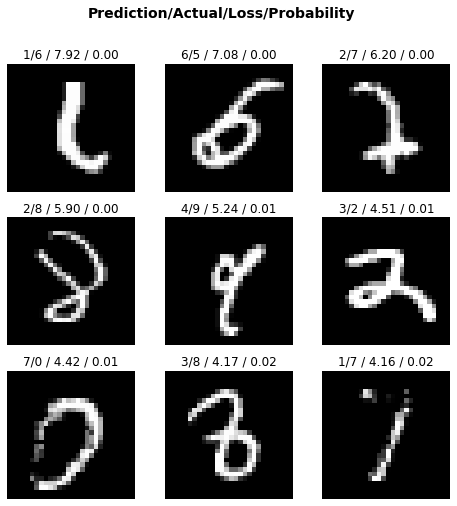

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(8,8))

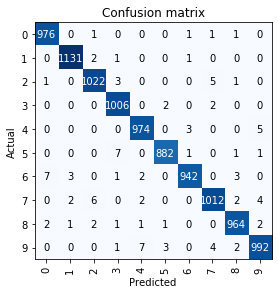

In [13]:
interp.plot_confusion_matrix()

### See if the model is consistently accurate across classes 

it isn't ... no problem for what we're doing here - but this could be significant in the real world.

In [14]:
# default set of functions that can calculate rates from a confusion matrix
default_cm_rate_fns = {
    'accuracy': lambda total,tp,tn,fp,fn: (tp+tn)/total, 
    'sensitiviy/recall': lambda total,tp,tn,fp,fn: tp/(tp+fn), 
    'specificity': lambda total,tp,tn,fp,fn: tn/(tn+fp), 
    'precision': lambda total,tp,tn,fp,fn: tp/(tp+fp)
}

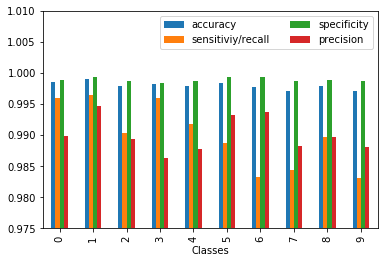

In [15]:
def cm_rates(interp: ClassificationInterpretation, cm_rate_fns=default_cm_rate_fns):
    "calculate rates for all functions in `cm_rate_fns`"
    d=[]
    cm=interp.confusion_matrix()
    total=cm.sum()
    for i, cls in enumerate(interp.data.classes):
        tp=cm[i][i]
        fn=cm[i].sum()-tp
        fp=cm[:,i].sum()-tp
        tn=total-tp-fn-fp
        d.append([cls]+[f(total,tp,tn,fp,fn) for f in cm_rate_fns.values()])
    return pd.DataFrame(d, columns=['Class']+list(cm_rate_fns.keys()))

cm_rates(interp).plot.bar(ylim=(.975,1.01)); plt.legend(ncol=2); plt.xlabel('Classes');

## Save everything needed to make predictions

In [16]:
learn.save('mnist-learn')
# export the model for inference
learn_export_file_name = 'mnist-learn-export.pkl'
learn.export(learn_export_file_name)
# Export the minimal state of the data bunch for inference 
data_export_file_name = 'mnist-data-export.pkl'
data.export(data_export_file_name)

In [17]:
import shutil
here = Path('.')
# copy the export files from fastai default to here
for file_name in [learn_export_file_name, data_export_file_name]:
    shutil.copyfile(path/file_name, here/file_name)